#### catatan: 
beberapa data taksonomi memang kosong dari NCBInya, misal data interaksi virus pycv malah terhubung ke genus capsicum bukan spesies capsicum. dan itu memang dari data GloBInya langsung

In [105]:
# # reset import package
# def reloadPackageOwn():
#     from importlib import reload  
#     import os # we use os.path.join, os.path.basename
#     import sys # we use sys.path
#     import glob # we use glob.glob
#     import importlib # we use importlib.import_module

#     import_folder = os.getcwd()
#     sys.path.append(import_folder) # this tells python to look in `import_folder` for imports
#     for src_file in glob.glob(os.path.join(import_folder, '*.py')):
#         name = os.path.basename(src_file)[:-3]
#         importlib.import_module(name)
#         reload(sys.modules[name])
#         importlib.import_module(name)
        
# reloadPackageOwn()

In [106]:
from tqdm import tqdm
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG, Vertex
from pyrdf2vec.embedders import FastText,Word2Vec
from pyrdf2vec.walkers import RandomWalker
from pyvis.network import Network
from sklearn.manifold import TSNE
from umap import UMAP
from SPARQLWrapper import SPARQLWrapper
from jcopml.plot import plot_missing_value

import plotly.express as px
import pandas as pd
import numpy as np
import requests
import os
import networkx as nx
import matplotlib.pyplot as plt

from modul.vectorReferenced import get_taxon_vector,cek_ncbi_id_by_wiki_id_via_string
from modul.filterNodeEdge import removeNodeAndEdgeByFilter,removeEdgesNotInNodes
from modul.helper_umum import contains_string_entire_column,contains_string_entire_column_boolean
#from process import cek_bfs, nx_to_pyviz

#### Parameter

In [107]:
data=[
    ('begomovirus_contoh_hasil','Pepper yellow leaf curl virus','Aleyrodidae','Bemisia Tabaci'),
    ('1cucu','Cucumber mosaic virus','Aphididae','Myzus persicae'),
    ('2cri','Tomato chlorosis virus','Aleyrodidae','Bemisia Tabaci'),
    ('3wai','Maize chlorotic dwarf virus','Cicadellidae','Graminella nigrifrons'),
    ('4beg','Tomato yellow leaf curl China virus','Aleyrodidae','Bemisia Tabaci'),
    ('5pol','Cereal yellow dwarf virus','Aphididae','Schizaphis graminum'),
    ('6pea','Pea enation mosaic virus 1','Aphididae','Acyrthosiphon pisum'),
    ('7cucur','Cucurbit yellow stunting disorder virus','Aleyrodidae','Bemisia Tabaci'),
    ('8ten','Rice stripe tenuivirus','Delphacidae','Laodelphax striatellus'),
    ('9fiji','Southern rice black-streaked dwarf virus','Delphacidae','Sogatella furcifera'),
    ('10capchlo','Capsicum chlorosis orthotospovirus','Thripidae','Thrips Palmi'),
    ('11barley','Barley yellow dwarf virus GAV','Aphididae','Sitobion avenae'),
    ('12tospot','Tomato spotted wilt orthotospovirus','Thripidae','Frankliniella occidentalis'),
    # error dibawah ini
    # ('+13Poty','Potyvirus','Aphididae','Myzus'),
    # ('+11tung','Tungrovirus','Nilaparvata','Nilaparvata'),
]

data_,nama_virus,acuan_,ujian_=data[0] # vektor acuan  #data virus
bobot_ed=1;
bobot_dc=1;

In [108]:
# link enpoint sparql ncbi_ontology
ncbi_ontology_url = 'http://localhost:3030/mydataset/query'

#### input data

In [109]:
#1
#baca data
df_node=pd.read_csv('dari_praproses/'+data_+'_node.csv',index_col=0) 
df_edge=pd.read_csv('dari_praproses/'+data_+'_edge.csv',index_col=0)

In [110]:
acuan_

'Aleyrodidae'

In [111]:
# pra-proses khusus proses
# hapus serangga yg cuma famili mengikuti acuan. soalnya klo cuma tampil famili apa gunanya?
filter_genus_sampai_species_null=(
    (df_node.genus.isnull()) &
    (df_node.species.isnull()) &
    (df_node['class']=='NCBI:50557_Insecta')
)
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[filter_genus_sampai_species_null], df_node,df_edge)

removeNodeAndEdgeByFilter
sebelum : 2786 5998
sesudah : 2757 5860


In [112]:
# pra-proses khusus proses
#isi data kosong. mengisi takson kosong, dengan takson sebelumnya, untuk tambalan
takson=[
    'superkingdom','kingdom','phylum','class','order','family','genus','species'
]

for x,i in enumerate(takson):
    if (i!='superkingdom'): #selain superkingdom update dengan data sebelumnya
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x-1]]+'^'+i
    else: 
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x+1]]+'^'+i

In [113]:
# pra-proses khusus proses
# eksperimen tambahan. bikin fakta tambahan, yaitu relasi virus utama dengan acuan 
virus_utama=df_node[df_node.virus_utama==True].taxon_id.to_list()
serangga_acuan=contains_string_entire_column(df_node,acuan_).taxon_id.to_list()

for i in virus_utama:
    for j in serangga_acuan:
        df_edge.loc[len(df_edge),['source_taxon_id','target_taxon_id','interaction_type']] = [i,j,'pathogenOf']

In [114]:
if(len(df_node[df_node['group']=="serangga"])<=2):
    print("cuma dua serangga")

#### Konversi graf

In [115]:
#3
#konversi graph 
gnx = nx.MultiDiGraph()
#node
for i,a in df_node.iterrows():
    #mulai disini akan digunakan taksonomi bahasa indonesia pada data.
    gnx.add_node(
        a['taxon_id'],
        label=a['taxon_name'],
        superkingdom=a['superkingdom'],
        kingdom=a['kingdom'],
        filum=a['phylum'],
        kelas=a['class'],
        ordo=a['order'],
        famili=a['family'],
        genus=a['genus'],
        spesies=a['species'],
        group=a['group'],
        color=a['color'],
    )
#edge
for i,a in df_edge.iterrows():
    gnx.add_edge(
        a['source_taxon_id'],
        a['target_taxon_id'],
        label=a['interaction_type'],
    )

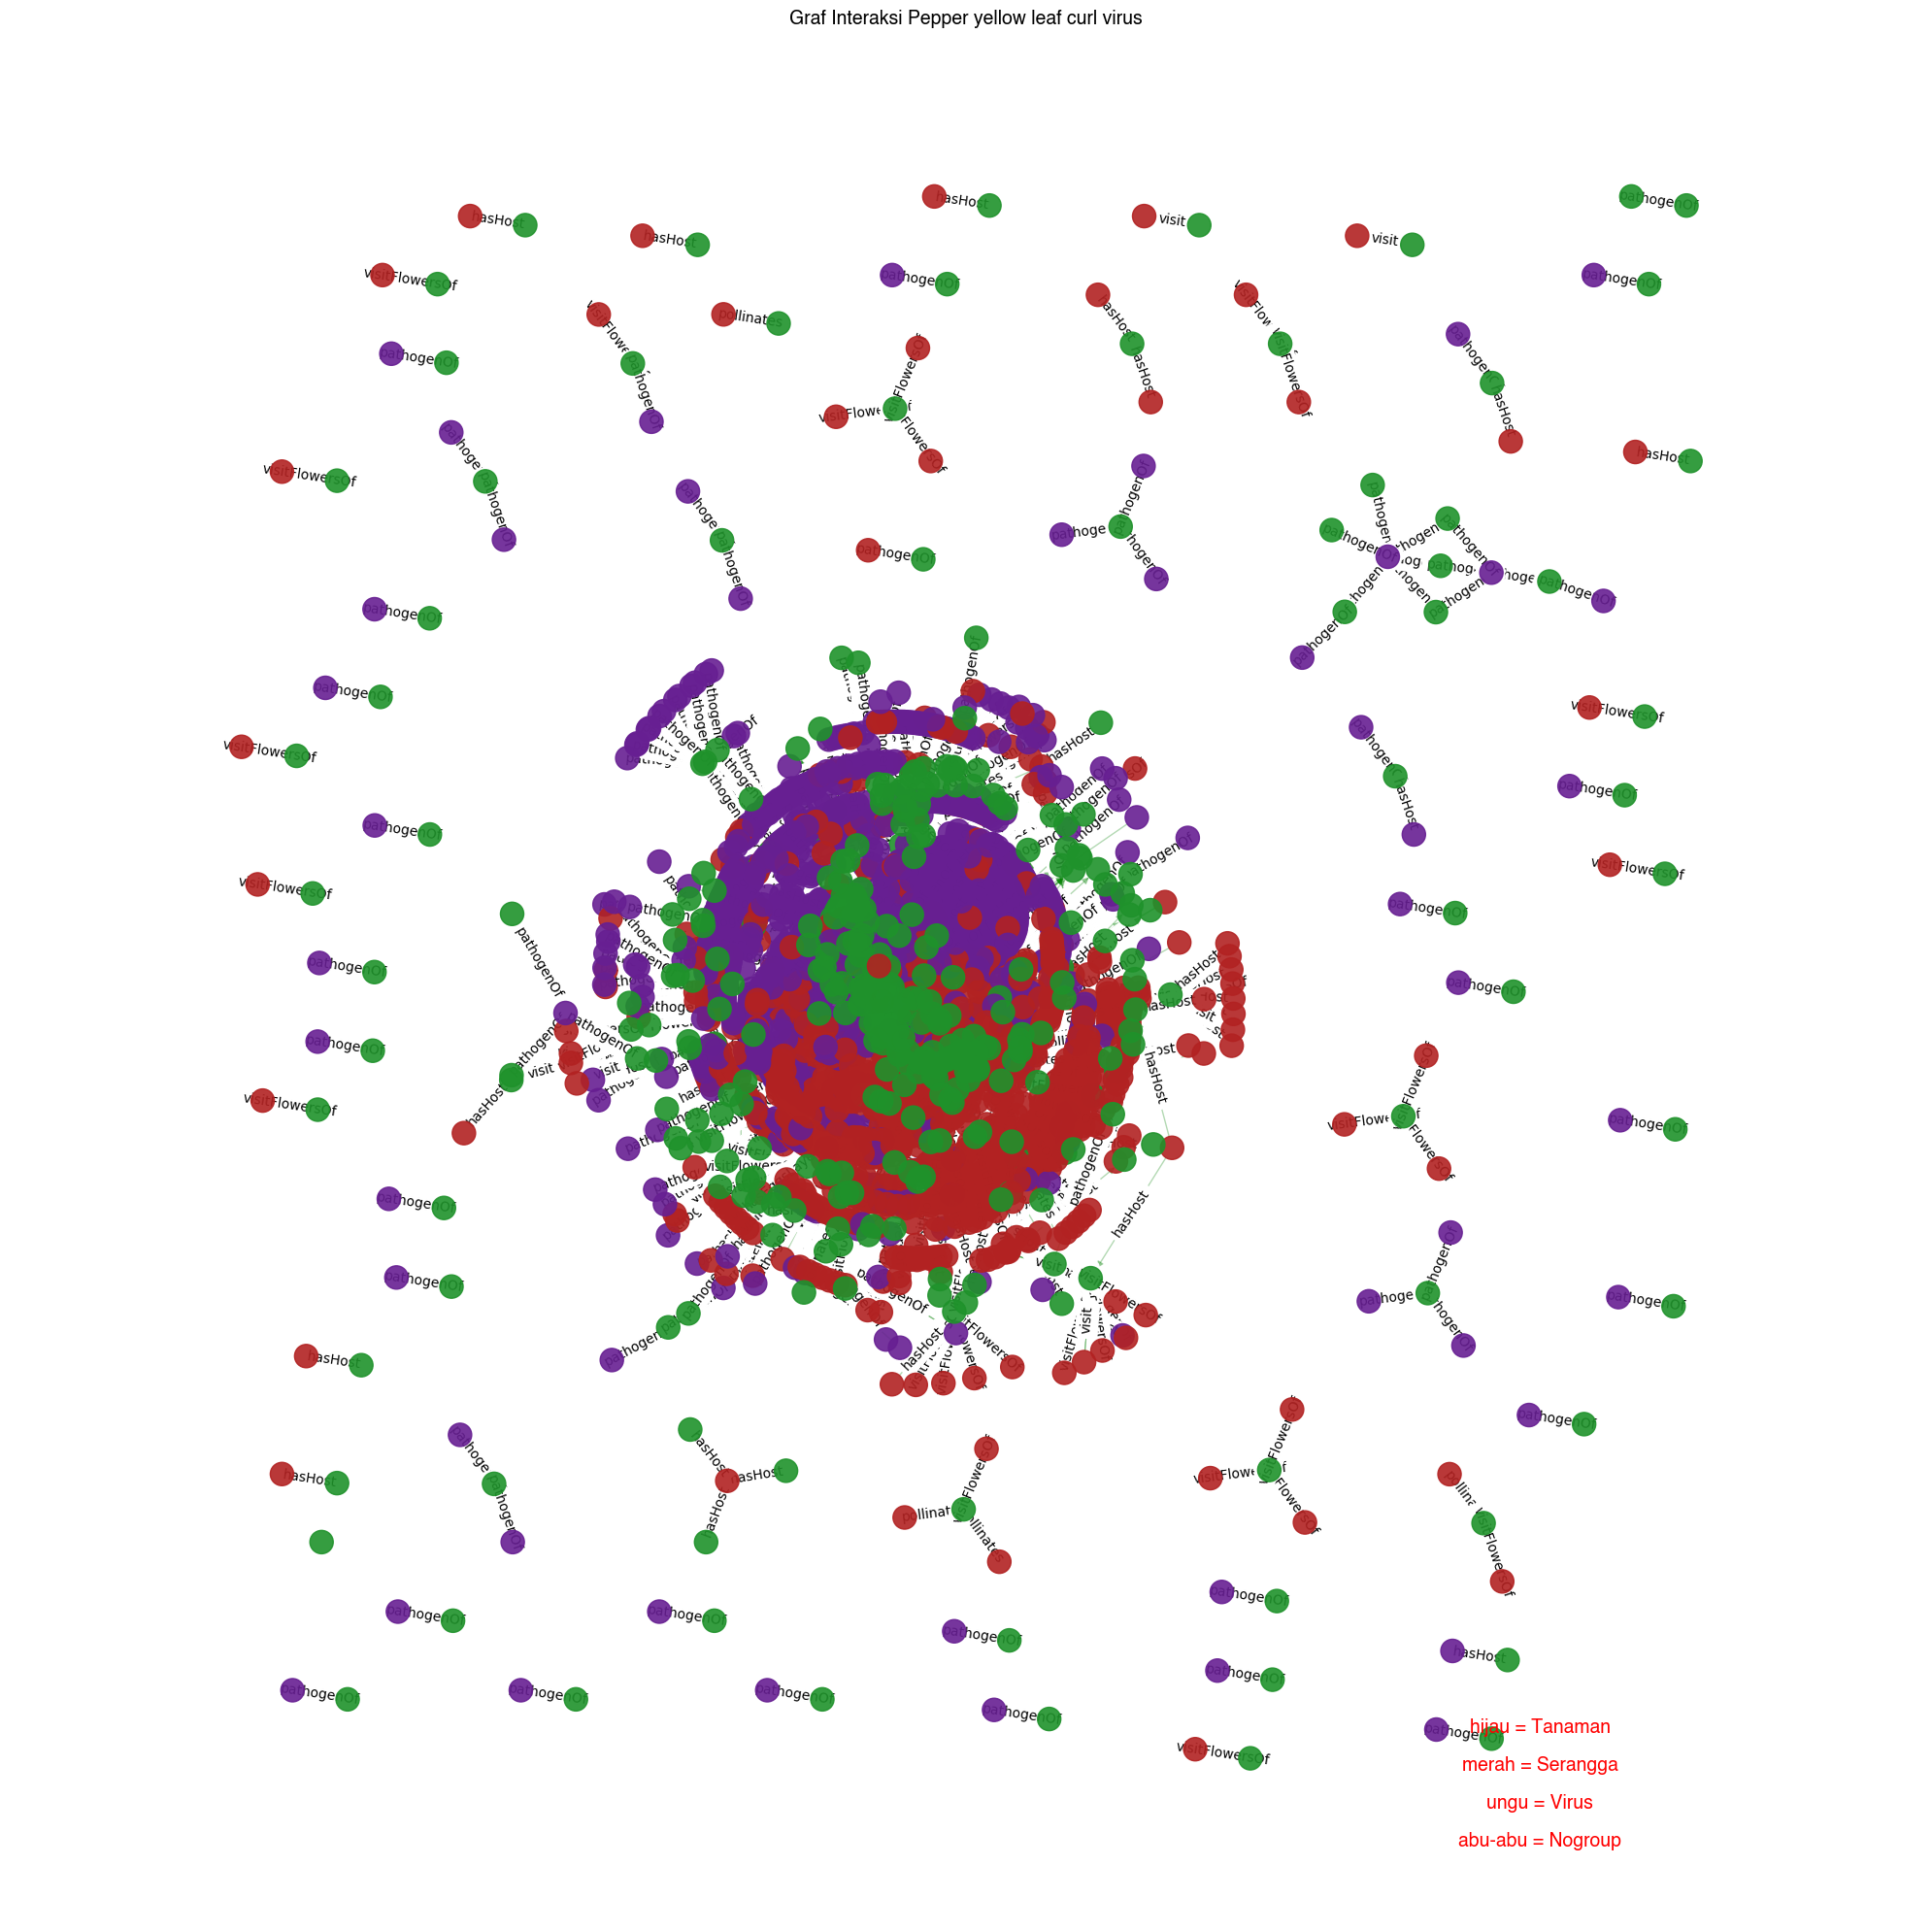

In [116]:
# cuma tampilan, visualisasi graf
G=gnx

fig, ax = plt.subplots(figsize=(20, 20))

# Generate layout for visualization
# pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_color=list(nx.get_node_attributes(G, "color").values()), alpha=0.9)

#node label
# for i in ['#b22222','#671f92','#1f922b','#EADDCA']: # filtering dengan bedakan warna node
#     label_options = {"ec": i, "fc": 'white', "alpha": 0.7}
#     nx.draw_networkx_labels(
#         nx.subgraph_view(G, filter_node=lambda n1: G.nodes(data=True)[n1].get("color", True) == i),
#         pos, 
#         font_size=10, 
#         bbox=label_options
#     )

#edge labels
edge_labels={x:i for i,x in zip(nx.get_edge_attributes(G, "label").values(),G.edges())}
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("Graf Interaksi "+nama_virus, font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "hijau = Tanaman",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.08,
    "merah = Serangga",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.06,
    "ungu = Virus",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.04,
    "abu-abu = Nogroup",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

In [117]:
# # cuma tampilan, visualisasi pyviz
from pyvis.network import Network
nt = Network('500px', '900px',directed=True,notebook=True)
# nt.show_buttons(filter_=['physics'])
nt.toggle_physics(True)

for i,data in gnx.nodes(data=True):
    nt.add_node(
        i,
        label= data['label'],
        superkingdom= data['superkingdom'],
        kingdom= data['kingdom'],
        filum= data['filum'],
        kelas= data['kelas'],
        ordo= data['ordo'],
        famili= data['famili'],
        genus= data['genus'],
        spesies= data['spesies'],
        group= data['group'],
        color= data['color'],
        )
    
for s,t,data in gnx.edges(data=True):
    nt.add_edge(
        s,
        t,
        label=data['label'])

nt.show("tmp.fig02.html")

In [118]:
#4 
# Degree Centrality
results_dc = nx.degree_centrality(gnx)
allnodes = gnx.nodes

In [119]:
# TAMBAHAN UNTUK CEK KUALITAS RELASI SERANGGA
def bfs_relasi_ke_virus_utama(gnx, to_search, virus_utama_ids):
    counter=0
    for edge in nx.bfs_edges(gnx.to_undirected(), source=to_search, depth_limit=2):
        s_id, o_id = edge

        s_label = gnx.nodes[s_id]['label'] +' '+s_id
        o_label = gnx.nodes[o_id]['label'] +' '+o_id

        # skip subjek to_search
        if (s_id == to_search) & (o_id in virus_utama_ids):
            print(s_label,'-->', o_label)
            counter+=1
    
    return counter

# tandai virus utama, sudah di praproses
# search_virus,taxon_,ncbi_id_=cek_ncbi_id_by_wiki_id_via_string(virus_utama)
# print("keyword virus utama: ",(search_virus,taxon_,ncbi_id_))
# df_node.loc[df_node[taxon_].str.contains(search_virus), ['virus_utama']] = True

# hitung relasi ke virus utama setiap serangga
virus_utama_ids=list(df_node[df_node['virus_utama']==True].taxon_id)
for idx,data in df_node[(df_node['group']=='serangga')].iterrows():
    _relasi = bfs_relasi_ke_virus_utama(gnx,data.taxon_id,virus_utama_ids)
    if(_relasi>0):
        print(idx,data.taxon_name,data.taxon_id)
        print(_relasi)
    df_node.loc[idx,'relasi_ke_virus_utama'] = _relasi
    # print("=================")
    # update DC pake bobot
    # reset_n=(len(gnx.nodes)-1)/(len([node for node, data in gnx.nodes(data=True) if data.get('group') == "serangga"])-1)
    # results[data.taxon_id] = 1+(results[data.taxon_id]*_relasi*reset_n) #1+(CM*w) #kalo pake jumlah serangga sebagai pembagi
    results_dc[data.taxon_id] = (results_dc[data.taxon_id]*_relasi) #1+(CM*w)

Bemisia tabaci NCBI:7038 --> Mungbean yellow mosaic India virus NCBI:223287
Bemisia tabaci NCBI:7038 --> Chenopodium leaf curl virus [VEM] NCBI:1032479
4473 Bemisia tabaci NCBI:7038
2


In [120]:
dc_serangga=[]
for node_id, rank in sorted(results_dc.items(), key=lambda item: item[1], reverse=True):
    if allnodes[node_id]['group'] in ['serangga']:
        label = gnx.nodes[node_id]['label']
        dc_serangga.append((rank, label, node_id))

In [121]:
dc_serangga

[(0.0783744557329463, 'Bemisia tabaci', 'NCBI:7038'),
 (0.0, 'Peru', 'NCBI:1634180'),
 (0.0, 'Phthiacnemia picta', 'NCBI:1228037'),
 (0.0, 'Dielis plumipes', 'NCBI:1574126'),
 (0.0, 'Microcephalothrips abdominalis', 'NCBI:407288'),
 (0.0, 'Thrips parvispinus', 'NCBI:1350418'),
 (0.0, 'Bathrips melanicornis', 'NCBI:1520562'),
 (0.0, 'Thrips hawaiiensis', 'NCBI:163894'),
 (0.0, 'Anthonomus eugenii', 'NCBI:122869'),
 (0.0, 'Contarinia maculipennis', 'NCBI:224263'),
 (0.0, 'Asphondylia gennadii', 'NCBI:153012'),
 (0.0, 'Scirtothrips dorsalis', 'NCBI:163899'),
 (0.0, 'Frankliniella intonsa', 'NCBI:163893'),
 (0.0, 'Frankliniella occidentalis', 'NCBI:133901'),
 (0.0, 'Aulacorthum solani', 'NCBI:202456'),
 (0.0, 'Osmia cornifrons', 'NCBI:124289'),
 (0.0, 'Apis', 'NCBI:7459'),
 (0.0, 'Exomalopsis', 'NCBI:156320'),
 (0.0, 'Bombus impatiens', 'NCBI:132113'),
 (0.0, 'Augochloropsis', 'NCBI:115078'),
 (0.0, 'Eristalis tenax', 'NCBI:198635'),
 (0.0, 'Liriomyza huidobrensis', 'NCBI:127405'),
 (0.0, 

In [122]:
#visualisasi data
# mengecek BFS Degree tertinggi
for to_search  in [dc_serangga[0][2]]:#["NCBI:7038"]:#"NCBI:33377","NCBI:7036",
    for edge in nx.bfs_edges(gnx.to_undirected(), source=to_search, depth_limit=1):
            s_id, o_id = edge

            s_label = gnx.nodes[s_id]['label'] +' '+s_id
            o_label = gnx.nodes[o_id]['label'] +' '+o_id
            o_grup = gnx.nodes[o_id]['group']

            # skip subjek to_search
            if (o_grup == 'virus'):
                print(s_label,'-->', o_label)
    print('===============')

Bemisia tabaci NCBI:7038 --> Ageratum yellow vein virus satellite DNA beta-[Ishigaki] NCBI:446569
Bemisia tabaci NCBI:7038 --> Mungbean yellow mosaic India virus NCBI:223287
Bemisia tabaci NCBI:7038 --> Hollyhock leaf crumple virus satellite DNA NCBI:169696
Bemisia tabaci NCBI:7038 --> Tomato golden mottle virus NCBI:223342
Bemisia tabaci NCBI:7038 --> Siegesbeckia yellow vein Guangxi virus NCBI:10814
Bemisia tabaci NCBI:7038 --> Bemisia tabaci Quaranja-like virus 2 NCBI:2840015
Bemisia tabaci NCBI:7038 --> Bemisia tabaci Quaranja-like virus 1 NCBI:2840014
Bemisia tabaci NCBI:7038 --> Bemisia tabaci Quaranja-like virus 3 NCBI:2840016
Bemisia tabaci NCBI:7038 --> Chenopodium leaf curl virus [VEM] NCBI:1032479
Bemisia tabaci NCBI:7038 --> Bemisia-associated genomovirus NfO NCBI:1986479
Bemisia tabaci NCBI:7038 --> Bemisia-associated genomovirus AdDF NCBI:1986477
Bemisia tabaci NCBI:7038 --> Bemisia-associated genomovirus AdO NCBI:1986478
Bemisia tabaci NCBI:7038 --> Sida golden mosaic vi

In [123]:
for i in [dc_serangga[0][2]]: #["NCBI:33377","NCBI:7036","NCBI:7038","NCBI:65032"]:
    print(gnx.nodes[i])

{'label': 'Bemisia tabaci', 'superkingdom': 'NCBI:2759_Eukaryota', 'kingdom': 'NCBI:33208_Metazoa', 'filum': 'NCBI:6656_Arthropoda', 'kelas': 'NCBI:50557_Insecta', 'ordo': 'NCBI:7524_Hemiptera', 'famili': 'NCBI:7036_Aleyrodidae', 'genus': 'NCBI:7037_Bemisia', 'spesies': 'NCBI:7038_Bemisia tabaci', 'group': 'serangga', 'color': '#b22222'}


In [124]:
#5
# Ambil data NCBI
# data acuan
data_acuan=get_taxon_vector(acuan_,ncbi_ontology_url)
print(data_acuan)
data_ujian=get_taxon_vector(ujian_,ncbi_ontology_url)
print(data_ujian)

[('famili', 'NCBI:7036_Aleyrodidae'), ('ordo', 'NCBI:7524_Hemiptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]
[('spesies', 'NCBI:7038_Bemisia tabaci'), ('genus', 'NCBI:7037_Bemisia'), ('famili', 'NCBI:7036_Aleyrodidae'), ('ordo', 'NCBI:7524_Hemiptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]


In [125]:
#6
#konversi node networkx ke RDF
URL = "http://pyRDF2Vec"
CUSTOM_KG = KG()

takson=[i[0] for i in data_acuan]
for i in ["superkingdom","kingdom","filum","kelas"]:
    takson.remove(i) 

# memasukan RDF serangga acuan
subj = Vertex(f"{URL}#SERANGGA_ACUAN")
for i,j in data_acuan:
    if(i not in ["superkingdom","kingdom","filum","kelas"]):
        j = j.replace(' ','-')
        obj = Vertex((URL+"#"+j))
        pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
        #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
        CUSTOM_KG.add_walk(subj, pred, obj)

# proses konversi 
for index,data in gnx.nodes(data=True):
    if(data['group']=='serangga'): #jika serangga
        subj = Vertex(URL+"#"+index)
        for i in takson:
            #if(isinstance(data[i], str)): #jika dia string atau tidak nan/kosong.
            #if(i not in ["superkingdom","kingdom","filum","kelas"]):
                id_takson=data[i].replace(' ','-')#.split('_')[0]
                obj = Vertex((URL+"#"+id_takson))
                pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
                #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
                CUSTOM_KG.add_walk(subj, pred, obj)
# CUSTOM_KG.literals=[
#         [f"{URL}#taxon_path_ids"],
#     ]
CUSTOM_KG.literals = [[URL+"#"+i] for i in takson]

In [126]:
#7
#embedding
# Ensure the determinism of this script by initializing a pseudo-random number.
RANDOM_STATE = 22
transformer = RDF2VecTransformer(
    # Use one worker threads for Word2Vec to ensure random determinism.
    # Must be used with PYTHONHASHSEED.
    Word2Vec(epochs=1000),
    # Extract a maximum of 10 walks of a maximum depth of 4 for each entity
    # using two processes and use a random state to ensure that the same walks
    # are generated for the entities.
    walkers=[RandomWalker(2, 5, n_jobs=2, with_reverse=False, random_state=RANDOM_STATE)],
    #verbose=1,
)
# transformer = RDF2VecTransformer(verbose=1)
# list entity yang akan diembedd. serangga acuan urutan terakhir
ent = [ URL+"#"+index for index,data in gnx.nodes(data=True) if(data['group']=='serangga') ] #jika serangga
ent.append(f"{URL}#SERANGGA_ACUAN")
# Fit the transformer to the knowledge graph and the entities.
embeddings, _ = transformer.fit_transform(
    CUSTOM_KG, #the KG
    ent, #entity
)

In [127]:
# visualisasi

# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X= UMAP().fit_transform(embeddings)
df_umap=pd.DataFrame(X,columns=['feature-vector-1','feature-vector-2'])


text=[]
labels=[]
for x in transformer._entities:
    if(x!="http://pyRDF2Vec#SERANGGA_ACUAN"):
        text.append(gnx.nodes[x.split("#")[-1]]['famili'].split('_')[-1])
        labels.append(gnx.nodes[x.split("#")[-1]]['label'])
    else:
        text.append("#TITIK_VEKTOR_ACUAN")
        labels.append("#TITIK_VEKTOR_ACUAN")
df_umap['text']=text
df_umap['labels']=labels

# # gnx.nodes[x.split("#")[-1]]['label']
# df_umap['text']=list(map(lambda x: x.split("#")[-1],transformer._entities))
fig = px.scatter(df_umap, x='feature-vector-1',y='feature-vector-2',text='text',hover_name='labels')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=650,
    title_text='reduced word2vec visualization'
)
fig.show()

In [128]:
#8
#euclidean distance

# buat dataframe
data_to_count=pd.DataFrame(embeddings, columns=list(range(0,100)))

# buat kolom label
ent=[data['label'] for index,data in gnx.nodes(data=True) if(data['group']=='serangga')] #jika serangga
ent.append("#SERANGGA_ACUAN")
data_to_count['label']=ent

#buat kolom entity
data_to_count['entity']=[i.replace("http://pyRDF2Vec#","") for i in transformer._entities]

# buat kolom hasil dc
for idx,row in data_to_count.iterrows(): #jika serangga acuan maka DC di isi nilai 1
    data_to_count.loc[idx,['dc_result']] = results_dc[row['entity']] if(row['entity']!="SERANGGA_ACUAN") else 1

#ambil koordinat acuan
acuan=next(data_to_count[data_to_count['label']=='#SERANGGA_ACUAN'].iterrows())[1]
acuan=np.array(tuple(acuan[i] for i in range(0,100)))
acuan

#hitung ED
for idx, row in data_to_count.iterrows():
    temp = np.array(tuple(row[i] for i in range(0,100)))
    data_to_count.loc[idx,['ed_result']] = np.linalg.norm(temp - acuan)

#drop data acuan
data_to_count.drop(data_to_count[data_to_count.label=="#SERANGGA_ACUAN"].index,inplace=True)

In [129]:
#drop kolom embedding
data_to_count.drop(columns=list(range(0,100)), inplace=True)

In [130]:
def minmax(data):
    return (data - data.min())/ (data.max() - data.min())

def std_scale(data):
    return (data - data.mean()) / data.std()


# simple scaling ed_result
# data_to_count["ed_result_scaled"] = data_to_count["ed_result"] / data_to_count["ed_result"].max()
data_to_count['ed_result_scaled'] = minmax(data_to_count['ed_result'])


# scaling dc 
# # dengan std
# data_to_count['dc_result_scaled'] = data_to_count['dc_result'] - data_to_count['dc_result'].mode()[0]
# # data_to_count['dc_result_scaled'] = data_to_count['dc_result']
# # lagi dengan minmax
# data_to_count["dc_result_scaled"] = data_to_count["dc_result_scaled"] / data_to_count["dc_result_scaled"].max()

# Perform scaling using standard deviation
# data_to_count['dc_result_scaled'] = std_scale(data_to_count['dc_result'])
# data_to_count['dc_result_scaled'] = minmax(data_to_count['dc_result_scaled'])

data_to_count['dc_result_scaled'] = minmax(data_to_count['dc_result'])


In [131]:
data_to_count

,label,entity,dc_result,ed_result,ed_result_scaled,dc_result_scaled
0,Peru,NCBI:1634180,0.000000,4.007938,0.962591,0.0
1,Phthiacnemia picta,NCBI:1228037,0.000000,2.050190,0.449344,0.0
2,Dielis plumipes,NCBI:1574126,0.000000,3.447303,0.815613,0.0
3,Microcephalothrips abdominalis,NCBI:407288,0.000000,3.437642,0.813081,0.0
4,Thrips parvispinus,NCBI:1350418,0.000000,3.419421,0.808304,0.0
...,...,...,...,...,...,...
1101,Encarsia lutea,NCBI:121802,0.000000,3.366508,0.794432,0.0
1102,Aphelinus asychis,NCBI:163151,0.000000,3.387278,0.799877,0.0
1103,Encarsia inaron,NCBI:121801,0.000000,3.446554,0.815417,0.0
1104,Encarsia sophia,NCBI:121815,0.000000,3.343471,0.788393,0.0


In [132]:
#9
#hitung kombinasi
# for idx, row in data_to_count.iterrows():
#     _dc = row['dc_result_scaled']
#     _ed=( (row['ed_result_scaled']) if row['ed_result_scaled']!=0 else 1)
#     data_to_count.loc[idx,['result']] = _dc/_ed

data_to_count['result'] = (1+data_to_count['dc_result_scaled']) / (1+data_to_count['ed_result_scaled'])

# simple scaling result (final/kombinasi)
data_to_count['result'] = data_to_count['result'] / data_to_count['result'].max()

# Pengujian

In [133]:
# DC
data_to_count=data_to_count.sort_values('dc_result',ascending=False).reset_index(drop=True)
data_to_count[['label','entity','dc_result']]

,label,entity,dc_result
0,Bemisia tabaci,NCBI:7038,0.078374
1,Junonia hierta cebrene,NCBI:2915464,0.000000
2,Oxydema longulum,NCBI:1482283,0.000000
3,Sarucallis kahawaluokalani,NCBI:527939,0.000000
4,Abaeis mexicana mexicana,NCBI:42450,0.000000
...,...,...,...
1101,Ephyriades brunnea floridensis,NCBI:2201549,0.000000
1102,Cyclargus ammon,NCBI:689480,0.000000
1103,Scolia nobilitata,NCBI:2742972,0.000000
1104,Dielis trifasciata,NCBI:2928476,0.000000


In [134]:

# Pengujian dc
for urutan in range(0,5):
    takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
    id_hasil=data_to_count.iloc[urutan].entity
    cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
    cek_ujian= { k:v for k,v in data_ujian if k in takson }
    # print(acuan_,'->', data_)
    # print('ujian ',cek_ujian)
    print('hasil ',cek_hasil)
    cek=0
    for i in reversed(takson):
        cekk=cek_hasil[i]==cek_ujian[i]
        cek+=cekk
        # print(i, cekk)
    print(cek/len(takson))

hasil  {'spesies': 'NCBI:7038_Bemisia tabaci', 'genus': 'NCBI:7037_Bemisia', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
1.0
hasil  {'spesies': 'NCBI:396708_Junonia hierta', 'genus': 'NCBI:39707_Junonia', 'famili': 'NCBI:33415_Nymphalidae', 'ordo': 'NCBI:7088_Lepidoptera'}
0.0
hasil  {'spesies': 'GBIF:4292056_Oxydemalongulum', 'genus': 'NCBI:1482283_Oxydema', 'famili': 'NCBI:7042_Curculionidae', 'ordo': 'NCBI:7041_Coleoptera'}
0.0
hasil  {'spesies': 'NCBI:527939_Sarucallis kahawaluokalani', 'genus': 'NCBI:527938_Sarucallis', 'famili': 'NCBI:27482_Aphididae', 'ordo': 'NCBI:7524_Hemiptera'}
0.25
hasil  {'spesies': 'INAT_TAXON:1241365_Abaeismexicana', 'genus': 'INAT_TAXON:81728_Abaeis', 'famili': 'NCBI:7114_Pieridae', 'ordo': 'NCBI:7088_Lepidoptera'}
0.0


In [135]:
# ED
data_to_count=data_to_count.sort_values('ed_result',ascending=True).reset_index(drop=True)
data_to_count[['label','entity','ed_result']]

,label,entity,ed_result
0,Trialeurodes vaporariorum,NCBI:88556,0.336195
1,Bemisia afer,NCBI:166114,0.400983
2,Aleurodicus dispersus,NCBI:267823,0.402135
3,Bemisia tabaci,NCBI:7038,0.466363
4,Alydus pilosulus,NCBI:1863032,1.664867
...,...,...,...
1101,Sapyga centrata,NCBI:411721,4.062251
1102,Oecanthus pellucens,NCBI:2567088,4.062982
1103,Zacompsia fulva,NCBI:1572576,4.090483
1104,Megaselia fungicola,NCBI:36165,4.116443


In [136]:
# Pengujian ed
for urutan in range(0,3):
    takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
    id_hasil=data_to_count.iloc[urutan].entity
    cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
    cek_ujian= { k:v for k,v in data_ujian if k in takson }
    # print(acuan_,'->', data_)
    # print('ujian ',cek_ujian)
    print('hasil ',cek_hasil)
    cek=0
    for i in reversed(takson):
        cekk=cek_hasil[i]==cek_ujian[i]
        cek+=cekk
        # print(i, cekk)
    print(cek/len(takson))

hasil  {'spesies': 'NCBI:88556_Trialeurodes vaporariorum', 'genus': 'NCBI:88555_Trialeurodes', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:166114_Bemisia afer', 'genus': 'NCBI:7037_Bemisia', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.75
hasil  {'spesies': 'NCBI:267823_Aleurodicus dispersus', 'genus': 'NCBI:30098_Aleurodicus', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5


In [137]:
# final score kombinasi
data_to_count=data_to_count.sort_values('result',ascending=False).reset_index(drop=True)
data_to_count[['label','dc_result','ed_result','result']]

,label,dc_result,ed_result,result
0,Bemisia tabaci,0.078374,0.466363,1.000000
1,Trialeurodes vaporariorum,0.000000,0.336195,0.517063
2,Bemisia afer,0.000000,0.400983,0.508427
3,Aleurodicus dispersus,0.000000,0.402135,0.508276
4,Alydus pilosulus,0.000000,1.664867,0.383485
...,...,...,...,...
1101,Sapyga centrata,0.000000,4.062251,0.261562
1102,Oecanthus pellucens,0.000000,4.062982,0.261536
1103,Zacompsia fulva,0.000000,4.090483,0.260586
1104,Megaselia fungicola,0.000000,4.116443,0.259695


In [138]:
# Pengujian kombinasi
for urutan in range(0,5):
    takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
    id_hasil=data_to_count.iloc[urutan].entity
    cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
    cek_ujian= { k:v for k,v in data_ujian if k in takson }
    # print(acuan_,'->', data_)
    # print('ujian ',cek_ujian)
    print('hasil ',cek_hasil)
    cek=0
    for i in reversed(takson):
        cekk=cek_hasil[i]==cek_ujian[i]
        cek+=cekk
        # print(i, cekk)
    print(cek/len(takson))

hasil  {'spesies': 'NCBI:7038_Bemisia tabaci', 'genus': 'NCBI:7037_Bemisia', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
1.0
hasil  {'spesies': 'NCBI:88556_Trialeurodes vaporariorum', 'genus': 'NCBI:88555_Trialeurodes', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:166114_Bemisia afer', 'genus': 'NCBI:7037_Bemisia', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.75
hasil  {'spesies': 'NCBI:267823_Aleurodicus dispersus', 'genus': 'NCBI:30098_Aleurodicus', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:1863032_Alydus pilosulus', 'genus': 'NCBI:881520_Alydus', 'famili': 'NCBI:41702_Alydidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.25


In [139]:
# Pengujian kombinasi
# cek=1
# takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
# urutan=0
# while cek/len(takson)>0:
#     id_hasil=data_to_count.iloc[urutan].entity
#     cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
#     cek_ujian= { k:v for k,v in data_ujian if k in takson }
#     # print(acuan_,'->', data_)
#     # print('ujian ',cek_ujian)
#     print('hasil ', urutan ,cek_hasil)
#     cek=0
#     for i in reversed(takson):
#         cekk=cek_hasil[i]==cek_ujian[i]
#         cek+=cekk
#         # print(i, cekk)
#     print(cek/len(takson))
#     urutan+=1

# Visualisasi Hasil Analisis

In [ ]:
import plotly.graph_objects as go

to_itter=data_to_count.sort_values('dc_result',ascending=False).reset_index(drop=True)[:10]

label=[]
degree=[]
for index,data in to_itter.sort_values('dc_result',ascending=True).reset_index(drop=True).iterrows():
    label.append(data.label)
    degree.append(data.dc_result)

fig = go.Figure(data=go.Bar(
    x=degree,
    y=label,
    orientation='h'
))

fig.update_layout(
    title='Degree centrality',
    xaxis_title='Degree',
    yaxis_title='Insect'
)

fig.show()

In [ ]:
to_itter=data_to_count.sort_values('ed_result',ascending=True).reset_index(drop=True)[:10]

label=[]
degree=[]
for index,data in to_itter.sort_values('ed_result',ascending=False).reset_index(drop=True).iterrows():
    label.append(data.label)
    degree.append(data.ed_result)

fig = go.Figure(data=go.Bar(
    x=degree,
    y=label,
    orientation='h'
))

fig.update_layout(
    title='Euclidean distance',
    xaxis_title='Distance',
    yaxis_title='Insect'
)

fig.show()

In [ ]:
import plotly.graph_objects as go

to_itter=data_to_count.sort_values('result',ascending=False).reset_index(drop=True)[:10]

label=[]
degree=[]
for index,data in to_itter.sort_values('result',ascending=True).reset_index(drop=True).iterrows():
    label.append(data.label)
    degree.append(data.result)

fig = go.Figure(data=go.Bar(
    x=degree,
    y=label,
    orientation='h'
))

fig.update_layout(
    title='final score',
    xaxis_title='Score',
    yaxis_title='Insect'
)

fig.show()

# Dibawah ini tidak termasuk

In [ ]:
#visualisasi data
# mengecek BFS Degree tertinggi
for edge in nx.bfs_edges(gnx.to_undirected(), source="NCBI:7038", depth_limit=1):
        s_id, o_id = edge

        s_label = gnx.nodes[s_id]['label'] +' '+s_id
        o_label = gnx.nodes[o_id]['label'] +' '+o_id
        o_grup = gnx.nodes[o_id]['group']

        # skip subjek to_search

        print(s_label,'-->', o_label)
print('===============')